<a href="https://colab.research.google.com/github/Fiendi/Data-Augmentation-with-K-NN/blob/main/KNN_TUBES_SLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls /content/drive


MyDrive


   K     Metric  Accuracy Mean  Accuracy Std
0  3  euclidean       0.761875      0.027266
1  3  manhattan       0.765000      0.020965
2  3     cosine       0.459750      0.011770
3  5  euclidean       0.772000      0.026755
4  5  manhattan       0.774625      0.027216
5  5     cosine       0.480875      0.005457
6  7  euclidean       0.770125      0.027688
7  7  manhattan       0.775750      0.032274
8  7     cosine       0.490500      0.011887
Best parameters - K: 7, Metric: manhattan, Best Accuracy: 0.77575


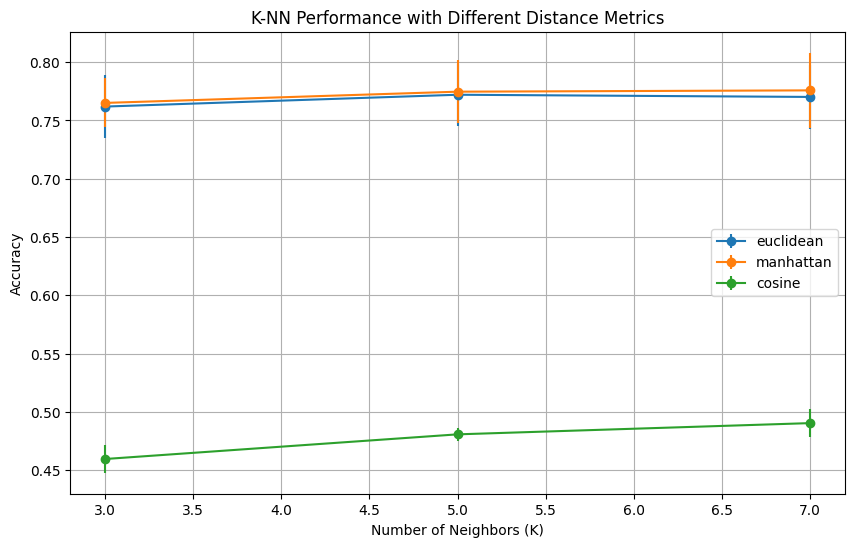

In [5]:
import os
import glob
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# Function to calculate waveform length
def waveform_length(epoch):
    return np.sum(np.abs(np.diff(epoch)))

# Function to calculate interquartile range
def interquartile_range(epoch):
    return np.percentile(epoch, 75) - np.percentile(epoch, 25)

# Function to calculate standard deviation
def standard_deviation(epoch):
    return np.std(epoch)

# Path to the datasets folder in Google Drive
base_path = '/content/drive/MyDrive/DATASET/'

# Load data
def load_data(directory):
    data = []
    for filename in glob.glob(os.path.join(directory, '*.txt')):
        with open(filename, 'r', encoding='utf-8') as file:
            data.append(file.read())
    return data

sets = ['SET A', 'SET B', 'SET C', 'SET D', 'SET E']
data = {s: load_data(os.path.join(base_path, s)) for s in sets}

# Combine data into a single DataFrame
all_data = []
labels = []
for label, s in enumerate(sets):
    for doc in data[s]:
        all_data.append(doc)
        labels.append(label)

df = pd.DataFrame({'EEG_Signal': all_data, 'Label': labels})

# Data Preprocessing: Cleaning and dividing into epochs
def clean_and_epoch(signal, epoch_length=200):
    # Split signal into individual numerical values
    signal_values = np.array(signal.split(), dtype=float)

    # Divide into epochs of specified length
    epochs = [signal_values[i:i + epoch_length] for i in range(0, len(signal_values), epoch_length)]
    return epochs

df['Epochs'] = df['EEG_Signal'].apply(clean_and_epoch)

# Feature Extraction
def extract_features(epochs):
    features = []
    for epoch in epochs:
        if len(epoch) == 200:
            wl = waveform_length(epoch)
            iqr = interquartile_range(epoch)
            std = standard_deviation(epoch)
            features.append([wl, iqr, std])
    return features

df['Features'] = df['Epochs'].apply(extract_features)

# Flatten the DataFrame to have one row per epoch
features = []
labels = []
for idx, row in df.iterrows():
    for feature in row['Features']:
        features.append(feature)
        labels.append(row['Label'])

features_df = pd.DataFrame(features, columns=['Waveform_Length', 'IQR', 'Std'])
labels_df = pd.DataFrame(labels, columns=['Label'])

# Combine features and labels into a single DataFrame
final_df = pd.concat([features_df, labels_df], axis=1)

# Prepare data for K-NN
X = final_df.drop('Label', axis=1)
y = final_df['Label']

# Define K-NN parameters
k_values = [3, 5, 7]
distance_metrics = ['euclidean', 'manhattan', 'cosine']
best_score = 0

# DataFrame to store results
results = []

# K-NN implementation and evaluation with standard deviation
for k in k_values:
    for metric in distance_metrics:
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
        scores = cross_val_score(knn, X, y, cv=5, scoring='accuracy')
        mean_score = np.mean(scores)
        std_score = np.std(scores) # Standard deviation of accuracy
        results.append({'K': k, 'Metric': metric, 'Accuracy Mean': mean_score, 'Accuracy Std': std_score})
        if mean_score > best_score:
            best_score = mean_score
            best_params = (k, metric)

# Create DataFrame for results
results_df = pd.DataFrame(results)

# Display results as a table
print(results_df)

print(f'Best parameters - K: {best_params[0]}, Metric: {best_params[1]}, Best Accuracy: {best_score}')

# Visualize the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for metric in distance_metrics:
    subset = results_df[results_df['Metric'] == metric]
    plt.errorbar(subset['K'], subset['Accuracy Mean'], yerr=subset['Accuracy Std'], label=metric, marker='o', linestyle='-')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Accuracy')
plt.title('K-NN Performance with Different Distance Metrics')
plt.legend()
plt.grid(True)
plt.show()


In [6]:
# Combine SET A, SET B, SET C, and SET D into one dataset
combined_df = df[df['Label'].isin([0, 1, 2, 3])]  # Selecting SET A, B, C, D
set_e_df = df[df['Label'] == 4]  # Selecting SET E

# Display feature numbers for SET ABCD vs SET E scenario
for idx, row in combined_df.iterrows():
    print(f"Epochs from SET {sets[row['Label']]}:")
    for epoch_idx, features in enumerate(row['Features']):
        print(f"Epoch {epoch_idx + 1}:")
        for feature_idx, feature in enumerate(features):
            print(f"Feature {feature_idx + 1}: {feature}")
    print()

for idx, row in set_e_df.iterrows():
    print(f"Epochs from SET E:")
    for epoch_idx, features in enumerate(row['Features']):
        print(f"Epoch {epoch_idx + 1}:")
        for feature_idx, feature in enumerate(features):
            print(f"Feature {feature_idx + 1}: {feature}")
    print()


Output streaming akan dipotong hingga 5000 baris terakhir.
Feature 1: 5496.0
Feature 2: 264.5
Feature 3: 153.31115085015833
Epoch 2:
Feature 1: 7686.0
Feature 2: 261.75
Feature 3: 162.88279344362928
Epoch 3:
Feature 1: 7193.0
Feature 2: 263.75
Feature 3: 159.637382135263
Epoch 4:
Feature 1: 7051.0
Feature 2: 268.75
Feature 3: 171.56447760244544
Epoch 5:
Feature 1: 7702.0
Feature 2: 265.0
Feature 3: 160.86744784138276
Epoch 6:
Feature 1: 7309.0
Feature 2: 333.25
Feature 3: 185.2089465981598
Epoch 7:
Feature 1: 5500.0
Feature 2: 359.25
Feature 3: 226.9831877034068
Epoch 8:
Feature 1: 8039.0
Feature 2: 390.25
Feature 3: 223.67506320553483
Epoch 9:
Feature 1: 5531.0
Feature 2: 284.0
Feature 3: 218.04006369243245
Epoch 10:
Feature 1: 5350.0
Feature 2: 383.75
Feature 3: 225.73201318156003
Epoch 11:
Feature 1: 7373.0
Feature 2: 336.0
Feature 3: 179.3414051467201
Epoch 12:
Feature 1: 5907.0
Feature 2: 364.0
Feature 3: 192.63310820053752
Epoch 13:
Feature 1: 5166.0
Feature 2: 335.0
Feature 3: 2

In [8]:
import numpy as np

# Function to calculate waveform length
def waveform_length(epoch):
    return np.sum(np.abs(np.diff(epoch)))

# Function to calculate interquartile range
def interquartile_range(epoch):
    return np.percentile(epoch, 75) - np.percentile(epoch, 25)

# Function to calculate standard deviation
def standard_deviation(epoch):
    return np.std(epoch)

# Function to clean and epochize signal
def clean_and_epoch(signal, epoch_length=200):
    # Assume signal is already loaded and preprocessed if necessary
    signal_values = np.array(signal.split(), dtype=float)
    epochs = [signal_values[i:i + epoch_length] for i in range(0, len(signal_values), epoch_length)]
    return epochs

# Example usage:
# Assume 'signal' is a string containing EEG signal data
signal = "0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0"  # Example data
epochs = clean_and_epoch(signal)
print("Epochs:", epochs)

# Example of feature extraction for one epoch
epoch_example = epochs[0]
wl = waveform_length(epoch_example)
iqr = interquartile_range(epoch_example)
std = standard_deviation(epoch_example)

print("Waveform Length:", wl)
print("Interquartile Range:", iqr)
print("Standard Deviation:", std)


Epochs: [array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])]
Waveform Length: 0.9
Interquartile Range: 0.45
Standard Deviation: 0.2872281323269014


In [9]:
print(combined_df.columns)
print(set_e_df.columns)


Index(['EEG_Signal', 'Label', 'Epochs', 'Features'], dtype='object')
Index(['EEG_Signal', 'Label', 'Epochs', 'Features'], dtype='object')


In [13]:
# Misalkan Anda memiliki fungsi extract_features yang mengembalikan list fitur untuk setiap epoch
df['Features'] = df['Epochs'].apply(extract_features)

# Flatten DataFrame untuk memiliki satu baris per epoch
features = []
labels = []
for idx, row in df.iterrows():
    for feature in row['Features']:
        features.append(feature)
        labels.append(row['Label'])

features_df = pd.DataFrame(features, columns=['Waveform_Length', 'IQR', 'Std'])
labels_df = pd.DataFrame(labels, columns=['Label'])

final_df = pd.concat([features_df, labels_df], axis=1)


In [14]:
print(final_df.columns)


Index(['Waveform_Length', 'IQR', 'Std', 'Label'], dtype='object')


In [17]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Fungsi untuk memuat data
def load_data(directory):
    all_data = []
    for file in os.listdir(directory):
        if file.endswith(".txt"):
            file_path = os.path.join(directory, file)
            data = np.loadtxt(file_path)
            all_data.append(data)
    return np.array(all_data)

# Direktori tempat data SET A disimpan
directory_path = '/content/drive/My Drive/DATASET/SET A'

# Memuat data
data = load_data(directory_path)

# Preprocessing data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)

# Membagi data menjadi training dan testing
X_train, X_test = train_test_split(data_normalized, test_size=0.2, random_state=42)

# Membangun model K-NN
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')  # Contoh penggunaan K=5 dan metrik euclidean
knn.fit(X_train, np.zeros(len(X_train)))  # Dummy label karena K-NN tidak memerlukan label kelas pada saat fit

# Evaluasi model
y_pred = knn.predict(X_test)
accuracy = accuracy_score(np.zeros(len(X_test)), y_pred)  # Dummy label untuk evaluasi
print(f"Akurasi Model K-NN untuk SET A: {accuracy * 100:.2f}%")


Akurasi Model K-NN untuk SET A: 100.00%


In [18]:
import numpy as np
import os
from scipy.signal import detrend
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Fungsi untuk memuat data
def load_data(directory):
    all_data = []
    for file in os.listdir(directory):
        if file.endswith(".txt"):
            file_path = os.path.join(directory, file)
            data = np.loadtxt(file_path)
            all_data.append(data)
    return np.array(all_data)

# Direktori tempat data SET A disimpan
directory_path = '/content/drive/My Drive/DATASET/SET A'

# Memuat data
data = load_data(directory_path)

# Preprocessing data
data_detrended = detrend(data, axis=1)  # Detrending
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data_detrended)

# Membagi data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(data_normalized, np.random.randint(0, 2, data_normalized.shape[0]), test_size=0.2, random_state=42)

# Membangun model K-NN
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')  # Contoh penggunaan K=5 dan metrik euclidean
knn.fit(X_train, y_train)

# Melakukan prediksi
y_pred = knn.predict(X_test)

# Evaluasi model
accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi Model K-NN untuk SET A: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred))


Akurasi Model K-NN untuk SET A: 50.00%
              precision    recall  f1-score   support

           0       0.50      0.90      0.64        10
           1       0.50      0.10      0.17        10

    accuracy                           0.50        20
   macro avg       0.50      0.50      0.40        20
weighted avg       0.50      0.50      0.40        20



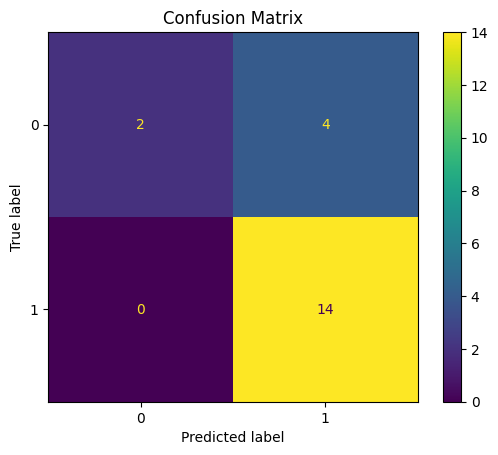

In [19]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.signal import detrend
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Fungsi untuk memuat data
def load_data(directory):
    all_data = []
    for file in os.listdir(directory):
        if file.endswith(".txt"):
            file_path = os.path.join(directory, file)
            data = np.loadtxt(file_path)
            all_data.append(data)
    return np.array(all_data)

# Direktori tempat data SET A disimpan
directory_path = '/content/drive/My Drive/DATASET/SET A'

# Memuat data
data = load_data(directory_path)

# Preprocessing data
data_detrended = detrend(data, axis=1)  # Detrending
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data_detrended)

# Membagi data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(data_normalized, np.random.randint(0, 2, data_normalized.shape[0]), test_size=0.2, random_state=42)

# Membangun model K-NN
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')  # Contoh penggunaan K=5 dan metrik euclidean
knn.fit(X_train, y_train)

# Plot confusion matrix
y_pred = knn.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()


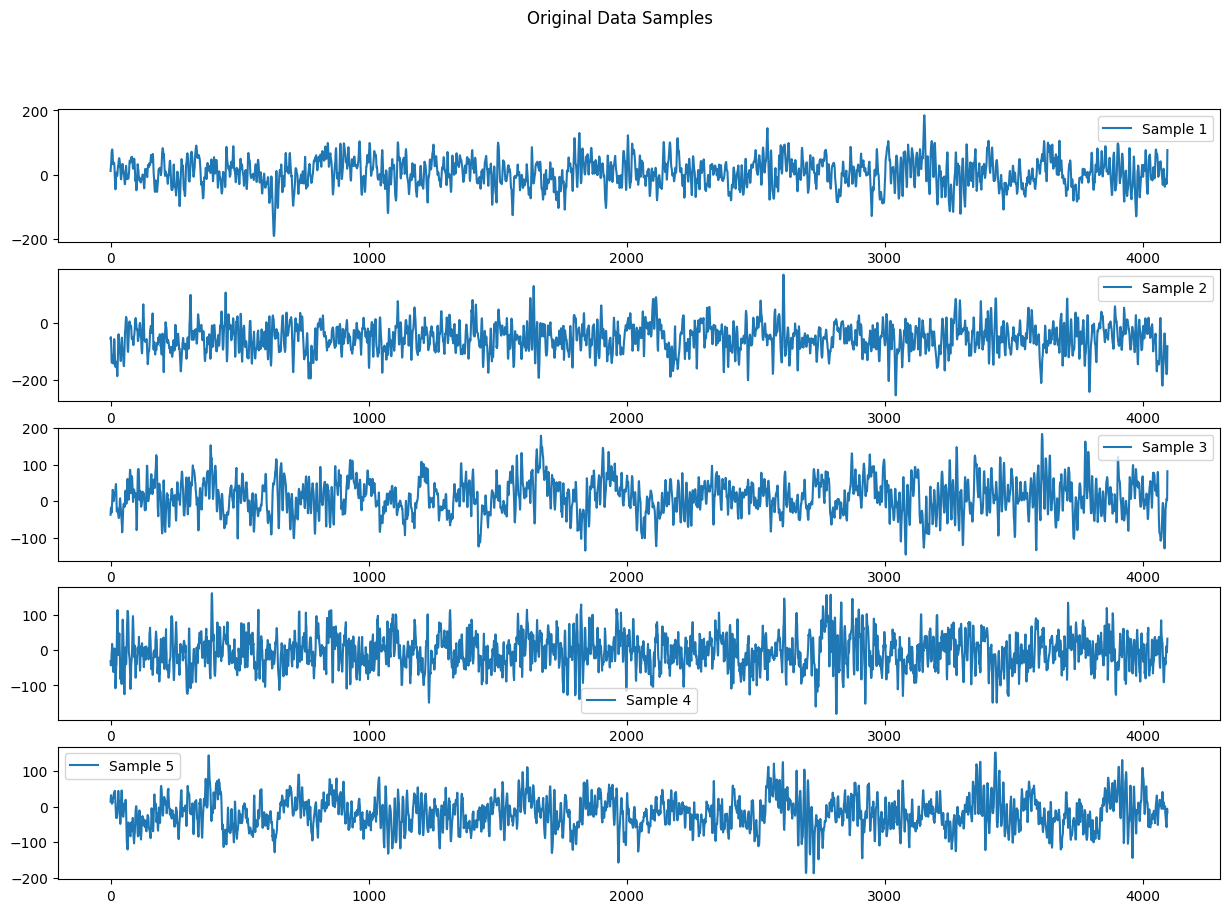

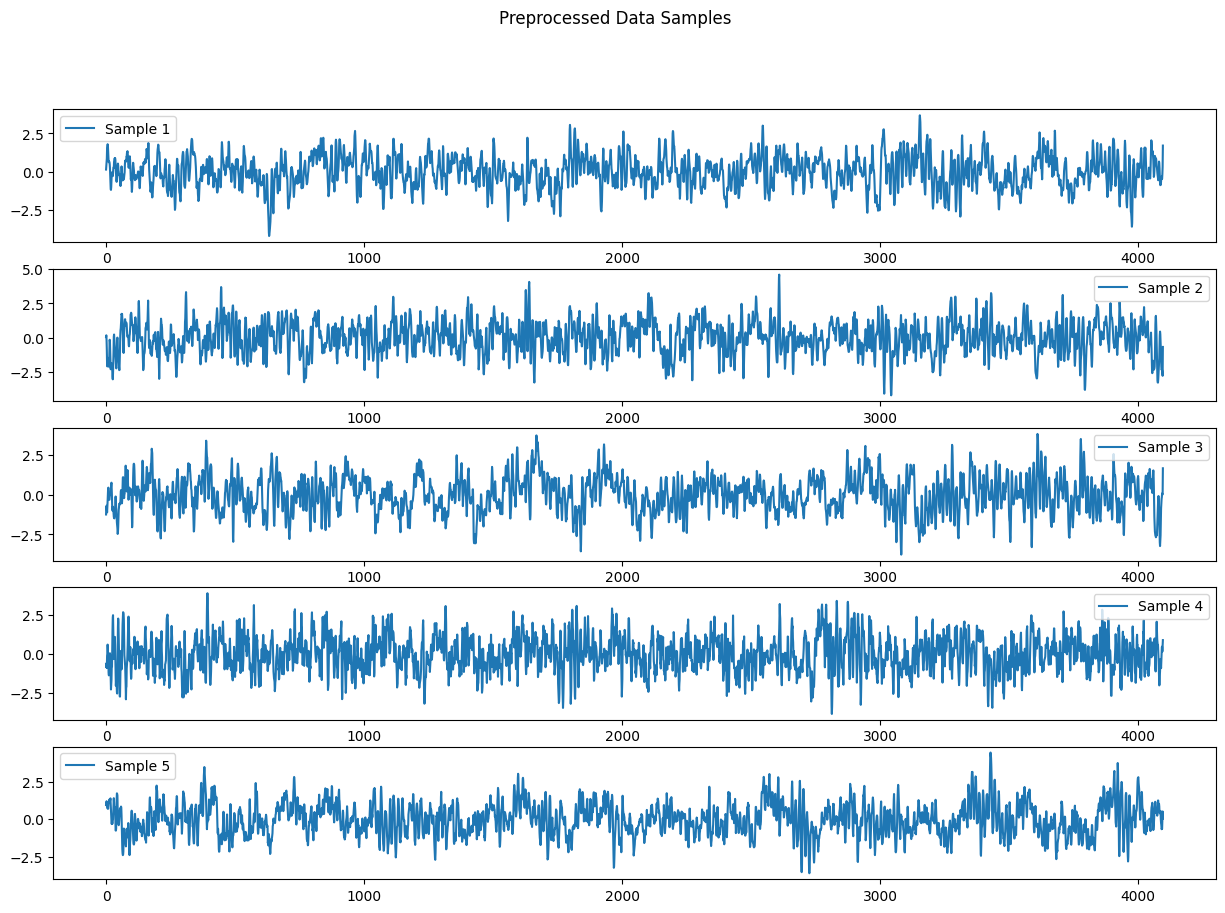

Akurasi Model K-NN untuk SET A: 50.00%
              precision    recall  f1-score   support

           0       0.50      0.10      0.17        10
           1       0.50      0.90      0.64        10

    accuracy                           0.50        20
   macro avg       0.50      0.50      0.40        20
weighted avg       0.50      0.50      0.40        20



In [20]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.signal import detrend
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Fungsi untuk memuat data
def load_data(directory):
    all_data = []
    for file in os.listdir(directory):
        if file.endswith(".txt"):
            file_path = os.path.join(directory, file)
            data = np.loadtxt(file_path)
            all_data.append(data)
    return np.array(all_data)

# Direktori tempat data SET A disimpan
directory_path = '/content/drive/My Drive/DATASET/SET A'

# Memuat data
data = load_data(directory_path)

# Menampilkan beberapa sampel data asli
plt.figure(figsize=(15, 10))
for i in range(5):
    plt.subplot(5, 1, i + 1)
    plt.plot(data[i], label=f'Sample {i+1}')
    plt.legend()
plt.suptitle('Original Data Samples')
plt.show()

# Preprocessing data
data_detrended = detrend(data, axis=1)  # Detrending
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data_detrended)

# Menampilkan beberapa sampel data setelah preprocessing
plt.figure(figsize=(15, 10))
for i in range(5):
    plt.subplot(5, 1, i + 1)
    plt.plot(data_normalized[i], label=f'Sample {i+1}')
    plt.legend()
plt.suptitle('Preprocessed Data Samples')
plt.show()

# Membagi data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(data_normalized, np.random.randint(0, 2, data_normalized.shape[0]), test_size=0.2, random_state=42)

# Membangun model K-NN
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')  # Contoh penggunaan K=5 dan metrik euclidean
knn.fit(X_train, y_train)

# Melakukan prediksi
y_pred = knn.predict(X_test)

# Evaluasi model
accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi Model K-NN untuk SET A: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred))


In [21]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.signal import detrend
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import f_classif
from sklearn.metrics import accuracy_score, classification_report

# Fungsi untuk memuat data dari direktori
def load_data(directory):
    all_data = []
    for file in os.listdir(directory):
        if file.endswith(".txt"):
            file_path = os.path.join(directory, file)
            data = np.loadtxt(file_path)
            all_data.append(data)
    return all_data

# Direktori tempat data disimpan
directory_paths = {
    'A': '/content/drive/My Drive/DATASET/SET A',
    'B': '/content/drive/My Drive/DATASET/SET B',
    'C': '/content/drive/My Drive/DATASET/SET C',
    'D': '/content/drive/My Drive/DATASET/SET D',
    'E': '/content/drive/My Drive/DATASET/SET E'
}

# Memuat data
data = {}
for key, path in directory_paths.items():
    data[key] = load_data(path)
    print(f"Loaded {key}: {len(data[key])} files")

# Pastikan bahwa setiap set data telah dimuat dengan benar
for key in data.keys():
    print(f"Loaded {key}: {len(data[key])} files")

# Konversi list data menjadi array numpy dan pastikan semua data memiliki dimensi yang sama
data_arrays = {}
min_lengths = []

for key in data.keys():
    if len(data[key]) > 0:
        lengths = [len(sample) for sample in data[key]]
        min_lengths.append(min(lengths))
        min_length = min(lengths)
        data_arrays[key] = np.array([sample[:min_length] for sample in data[key]])
        print(f"Shape of {key}: {data_arrays[key].shape}")
    else:
        print(f"Set {key} is empty")

if len(min_lengths) > 0:
    min_length = min(min_lengths)
else:
    raise ValueError("No valid data files found in the datasets.")

# Menggabungkan data dari SET A, B, D menjadi satu (mengabaikan SET C karena kosong)
data_abcd = np.concatenate([data_arrays['A'], data_arrays['B'], data_arrays['D']], axis=0)
labels_abcd = np.zeros(data_abcd.shape[0])  # Label 0 untuk gabungan data non-seizure

data_e = data_arrays['E']
labels_e = np.ones(data_e.shape[0])  # Label 1 untuk data seizure

# Menggabungkan data A, B, D dan E untuk klasifikasi
X = np.concatenate([data_abcd, data_e], axis=0)
y = np.concatenate([labels_abcd, labels_e], axis=0)

# Preprocessing data
X_detrended = detrend(X, axis=1)  # Detrending
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_detrended)

# Membagi data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

# Seleksi fitur menggunakan ANOVA F-test
f_scores, p_values = f_classif(X_train, y_train)

# Memilih fitur-fitur teratas berdasarkan skor F tertinggi
num_top_features = 15
top_features_idx = np.argsort(f_scores)[-num_top_features:]

# Memilih hanya fitur-fitur teratas untuk data training dan testing
X_train_selected = X_train[:, top_features_idx]
X_test_selected = X_test[:, top_features_idx]

# Membangun model K-NN
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')  # Contoh penggunaan K=5 dan metrik euclidean
knn.fit(X_train_selected, y_train)

# Melakukan prediksi
y_pred = knn.predict(X_test_selected)

# Evaluasi model
accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi Model K-NN untuk SET A, B, D vs E: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred))


Loaded A: 100 files
Loaded B: 100 files
Loaded C: 0 files
Loaded D: 100 files
Loaded E: 100 files
Loaded A: 100 files
Loaded B: 100 files
Loaded C: 0 files
Loaded D: 100 files
Loaded E: 100 files
Shape of A: (100, 4097)
Shape of B: (100, 4097)
Set C is empty
Shape of D: (100, 4097)
Shape of E: (100, 4097)
Akurasi Model K-NN untuk SET A, B, D vs E: 85.00%
              precision    recall  f1-score   support

         0.0       0.84      1.00      0.91        62
         1.0       1.00      0.33      0.50        18

    accuracy                           0.85        80
   macro avg       0.92      0.67      0.71        80
weighted avg       0.87      0.85      0.82        80



In [26]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.signal import detrend
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import f_classif
from sklearn.metrics import accuracy_score, classification_report

# Fungsi untuk memuat data dari direktori
def load_data(directory):
    all_data = []
    for file in os.listdir(directory):
        if file.endswith(".txt"):
            file_path = os.path.join(directory, file)
            data = np.loadtxt(file_path)
            all_data.append(data)
    return all_data

# Direktori tempat data disimpan
directory_paths = {
    'A': '/content/drive/My Drive/DATASET/SET A',
    'B': '/content/drive/My Drive/DATASET/SET B',
    'C': '/content/drive/My Drive/DATASET/SET C',
    'D': '/content/drive/My Drive/DATASET/SET D',
    'E': '/content/drive/My Drive/DATASET/SET E'
}

# Memuat data
data = {}
for key, path in directory_paths.items():
    data[key] = load_data(path)
    print(f"Loaded {key}: {len(data[key])} files")

# Konversi list data menjadi array numpy dan pastikan semua data memiliki dimensi yang sama
data_arrays = {}
min_lengths = []

for key in data.keys():
    if len(data[key]) > 0:
        lengths = [len(sample) for sample in data[key]]
        min_lengths.append(min(lengths))
        min_length = min(lengths)
        data_arrays[key] = np.array([sample[:min_length] for sample in data[key]])
        print(f"Shape of {key}: {data_arrays[key].shape}")
    else:
        print(f"Set {key} is empty")

if len(min_lengths) > 0:
    min_length = min(min_lengths)
else:
    raise ValueError("No valid data files found in the datasets.")

# Menggabungkan data dari SET A, B, D menjadi satu (mengabaikan SET C karena kosong)
data_abcd = np.concatenate([data_arrays['A'], data_arrays['B'], data_arrays['D']], axis=0)
labels_abcd = np.zeros(data_abcd.shape[0])  # Label 0 untuk gabungan data non-seizure

data_e = data_arrays['E']
labels_e = np.ones(data_e.shape[0])  # Label 1 untuk data seizure

# Menggabungkan data A, B, D dan E untuk klasifikasi
X = np.concatenate([data_abcd, data_e], axis=0)
y = np.concatenate([labels_abcd, labels_e], axis=0)

# Preprocessing data
X_detrended = detrend(X, axis=1)  # Detrending
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_detrended)

# Seleksi fitur menggunakan ANOVA F-test
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)
f_scores, p_values = f_classif(X_train, y_train)

# Memilih fitur-fitur teratas berdasarkan skor F tertinggi
num_top_features = 15
top_features_idx = np.argsort(f_scores)[-num_top_features:]

# Memilih hanya fitur-fitur teratas untuk data training dan testing
X_train_selected = X_train[:, top_features_idx]
X_test_selected = X_test[:, top_features_idx]

# Membangun model K-NN
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')  # Contoh penggunaan K=5 dan metrik euclidean
knn.fit(X_train_selected, y_train)

# Melakukan prediksi
y_pred = knn.predict(X_test_selected)

# Evaluasi model
accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi Model K-NN untuk SET ABCD vs E: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred))


Loaded A: 100 files
Loaded B: 100 files
Loaded C: 0 files
Loaded D: 100 files
Loaded E: 100 files
Shape of A: (100, 4097)
Shape of B: (100, 4097)
Set C is empty
Shape of D: (100, 4097)
Shape of E: (100, 4097)
Akurasi Model K-NN untuk SET ABCD vs E: 85.00%
              precision    recall  f1-score   support

         0.0       0.84      1.00      0.91        62
         1.0       1.00      0.33      0.50        18

    accuracy                           0.85        80
   macro avg       0.92      0.67      0.71        80
weighted avg       0.87      0.85      0.82        80



In [23]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.signal import detrend
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import f_classif
from sklearn.metrics import accuracy_score, classification_report

# Fungsi untuk memuat data dari direktori
def load_data(directory):
    all_data = []
    for file in os.listdir(directory):
        if file.endswith(".txt"):
            file_path = os.path.join(directory, file)
            data = np.loadtxt(file_path)
            all_data.append(data)
    return all_data

# Direktori tempat data disimpan
directory_paths = {
    'A': '/content/drive/My Drive/DATASET/SET A',
    'B': '/content/drive/My Drive/DATASET/SET B',
    'E': '/content/drive/My Drive/DATASET/SET E'
}

# Memuat data
data = {}
for key, path in directory_paths.items():
    data[key] = load_data(path)
    print(f"Loaded {key}: {len(data[key])} files")

# Konversi list data menjadi array numpy dan pastikan semua data memiliki dimensi yang sama
data_arrays = {}
min_lengths = []

for key in data.keys():
    if len(data[key]) > 0:
        lengths = [len(sample) for sample in data[key]]
        min_lengths.append(min(lengths))
        min_length = min(lengths)
        data_arrays[key] = np.array([sample[:min_length] for sample in data[key]])
        print(f"Shape of {key}: {data_arrays[key].shape}")
    else:
        print(f"Set {key} is empty")

if len(min_lengths) > 0:
    min_length = min(min_lengths)
else:
    raise ValueError("No valid data files found in the datasets.")

# Menggabungkan data dari SET A dan B menjadi satu (non-seizure)
data_ab = np.concatenate([data_arrays['A'], data_arrays['B']], axis=0)
labels_ab = np.zeros(data_ab.shape[0])  # Label 0 untuk gabungan data non-seizure

data_e = data_arrays['E']
labels_e = np.ones(data_e.shape[0])  # Label 1 untuk data seizure

# Menggabungkan data A, B, dan E untuk klasifikasi
X = np.concatenate([data_ab, data_e], axis=0)
y = np.concatenate([labels_ab, labels_e], axis=0)

# Preprocessing data
X_detrended = detrend(X, axis=1)  # Detrending
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_detrended)

# Seleksi fitur menggunakan ANOVA F-test (opsional)
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)
# f_scores, p_values = f_classif(X_train, y_train)

# Membangun model K-NN
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')  # Contoh penggunaan K=5 dan metrik euclidean
knn.fit(X_train, y_train)

# Melakukan prediksi
y_pred = knn.predict(X_test)

# Evaluasi model
accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi Model K-NN untuk SET AB vs E: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred))


Loaded A: 100 files
Loaded B: 100 files
Loaded E: 100 files
Shape of A: (100, 4097)
Shape of B: (100, 4097)
Shape of E: (100, 4097)
Akurasi Model K-NN untuk SET AB vs E: 66.67%
              precision    recall  f1-score   support

         0.0       0.66      1.00      0.79        38
         1.0       1.00      0.09      0.17        22

    accuracy                           0.67        60
   macro avg       0.83      0.55      0.48        60
weighted avg       0.78      0.67      0.56        60



In [24]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.signal import detrend
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import f_classif
from sklearn.metrics import accuracy_score, classification_report

# Fungsi untuk memuat data dari direktori
def load_data(directory):
    all_data = []
    for file in os.listdir(directory):
        if file.endswith(".txt"):
            file_path = os.path.join(directory, file)
            data = np.loadtxt(file_path)
            all_data.append(data)
    return all_data

# Direktori tempat data disimpan
directory_paths = {
    'A': '/content/drive/My Drive/DATASET/SET A',
    'E': '/content/drive/My Drive/DATASET/SET E'
}

# Memuat data
data = {}
for key, path in directory_paths.items():
    data[key] = load_data(path)
    print(f"Loaded {key}: {len(data[key])} files")

# Konversi list data menjadi array numpy dan pastikan semua data memiliki dimensi yang sama
data_arrays = {}
min_lengths = []

for key in data.keys():
    if len(data[key]) > 0:
        lengths = [len(sample) for sample in data[key]]
        min_lengths.append(min(lengths))
        min_length = min(lengths)
        data_arrays[key] = np.array([sample[:min_length] for sample in data[key]])
        print(f"Shape of {key}: {data_arrays[key].shape}")
    else:
        print(f"Set {key} is empty")

if len(min_lengths) > 0:
    min_length = min(min_lengths)
else:
    raise ValueError("No valid data files found in the datasets.")

# Menggunakan data dari SET A sebagai non-seizure
data_a = data_arrays['A']
labels_a = np.zeros(data_a.shape[0])  # Label 0 untuk data non-seizure

# Menggunakan data dari SET E sebagai seizure
data_e = data_arrays['E']
labels_e = np.ones(data_e.shape[0])  # Label 1 untuk data seizure

# Menggabungkan data A dan E untuk klasifikasi
X = np.concatenate([data_a, data_e], axis=0)
y = np.concatenate([labels_a, labels_e], axis=0)

# Preprocessing data
X_detrended = detrend(X, axis=1)  # Detrending
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_detrended)

# Membagi data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

# Membangun model K-NN
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')  # Contoh penggunaan K=5 dan metrik euclidean
knn.fit(X_train, y_train)

# Melakukan prediksi
y_pred = knn.predict(X_test)

# Evaluasi model
accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi Model K-NN untuk SET A vs E: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred))


Loaded A: 100 files
Loaded E: 100 files
Shape of A: (100, 4097)
Shape of E: (100, 4097)
Akurasi Model K-NN untuk SET A vs E: 52.50%
              precision    recall  f1-score   support

         0.0       0.53      1.00      0.69        21
         1.0       0.00      0.00      0.00        19

    accuracy                           0.53        40
   macro avg       0.26      0.50      0.34        40
weighted avg       0.28      0.53      0.36        40



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
